In [1]:
import numpy as np
import h5py as h5

import scipy as scp
import sklearn as skl
import matplotlib.pyplot as plt
import keras 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from keras.models import Sequential, Model
from keras.layers import Dense, GaussianNoise, Input, Conv2D, Flatten, MaxPooling2D, Dropout, Conv2DTranspose, Reshape
from keras.regularizers import l2

from mlhelpers4 import PlotLosses, plot_a_bunch_of_beams,make_dataset
plot_losses=PlotLosses()
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({'font.size': 10})
#plt.style.use('rs_paper.mplstyle')
import time

In [2]:
############# set these according to which offsets you want to run. 
############# If the file does not exist, you'll need to go run it in SRW_multiprocess.py 
offsets_mirror1 = True
offsets_mirror2 = False
rotations_mirror1 = True 
rotations_mirror2 = False
n_runs = 5000

input_str = 'datasets/beam_intensities_'
output_str = 'datasets/parameters_'
save_str = 'results/'
data_str = '' 
if offsets_mirror1:
    save_str += 'mirror1_offsets_'
    data_str += 'mirror1_offsets_'

if offsets_mirror2:
    save_str += 'mirror2_offsets_'
    data_str += 'mirror2_offsets_'

if rotations_mirror1:
    save_str += 'mirror1_rotations_'
    data_str += 'mirror1_rotations_'

if rotations_mirror2: 
    save_str += 'mirror2_rotations_'
    data_str += 'mirror2_rotations_'
    
images = np.load(input_str + data_str + str(n_runs) + 'runs.npy')
settings = np.load(output_str + data_str + str(n_runs) + 'runs.npy').reshape(n_runs, -1)
print(images.shape)
print(settings.shape)

(5000, 280, 280)
(5000, 6)


In [3]:
############# sets labels for automated plots for results 
labels = []
if offsets_mirror1:
    labels.append('dx1')

if offsets_mirror2:
    labels.append('dy2')

if rotations_mirror1: 
    #labels.append('thetax1')
    labels.append('thetay1')
    labels.append('thetaz1')
    
if rotations_mirror2: 
    labels.append('thetax2')
    #labels.append('thetay2')
    labels.append('thetaz2')

print(labels)
print(save_str)

['dx1', 'dy2', 'thetay1', 'thetaz1', 'thetax2', 'thetaz2']
results/mirror1_offsets_mirror2_offsets_mirror1_rotations_mirror2_rotations_


In [4]:
xs = np.linspace(0, np.shape(images)[1], np.shape(images)[1])
ys = np.linspace(0, np.shape(images)[2], np.shape(images)[2])
volume = images.shape[1]*images.shape[2]
norm = (np.sum(images, axis=(1,2))/volume).reshape(n_runs,1,1)

XX, YY = np.meshgrid(xs, ys)

x_prob = np.divide(images*XX,norm)
x_sqrd_prob = np.divide(images*(XX**2), norm)

y_prob = np.divide(images*YY,norm)
y_sqrd_prob = np.divide(images*(YY**2), norm)
print(y_sqrd_prob[0])

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.06585030e-08 3.74286661e-08 1.15624312e-07 ... 5.24989056e-07
  5.94452345e-07 6.72384049e-07]
 [2.58723106e-08 1.23373556e-07 3.72304998e-07 ... 1.40880346e-06
  2.14407778e-06 3.21568162e-06]
 ...
 [1.36919179e-03 2.51167333e-03 2.75074788e-03 ... 1.78001204e-02
  1.93739836e-02 2.07949990e-02]
 [4.67479992e-03 2.93478505e-03 3.01282066e-03 ... 8.81289268e-04
  2.56626719e-03 5.20839282e-03]
 [9.31268855e-03 3.73750621e-03 3.79426899e-03 ... 4.10376985e-03
  1.21308468e-02 1.79307775e-02]]


In [5]:
mean_x = np.mean(x_prob, axis=(1, 2)).reshape(n_runs,1,1)
print(mean_x[0])
mean_y = np.mean(y_prob, axis=(1, 2)).reshape(n_runs,1,1)
print(mean_y[0])

[[190.34495895]]
[[112.09864709]]


In [6]:
rms_x = np.sqrt(
    np.mean(
        (x_sqrd_prob - mean_x**2), axis=(1,2)
            )
    )

rms_y = np.sqrt(
    np.mean(
        (y_sqrd_prob - mean_y**2), axis=(1,2)
            )
    )

10.091487611120074
42.176010555299584
[[152.33910213]]
[[190.58879313]]


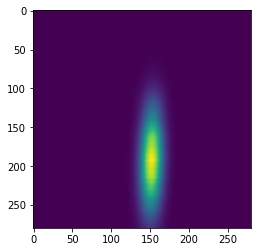

In [7]:
test_idx = 55
print(rms_x[test_idx])
print(rms_y[test_idx])
print(mean_x[test_idx])
print(mean_y[test_idx])
plt.imshow(images[test_idx])

In [8]:
X_vals = np.vstack((mean_x.reshape(n_runs,), mean_y.reshape(n_runs,), rms_x, rms_y)).T
x_labels = ['mean x', 'mean y', 'rms x', 'rms y']

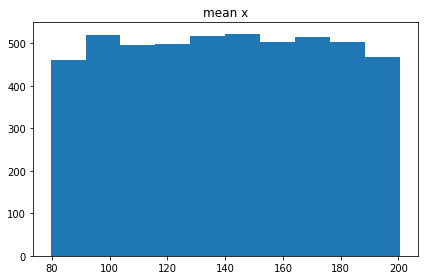

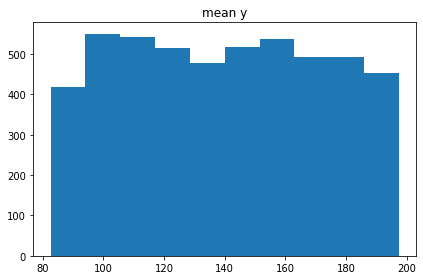

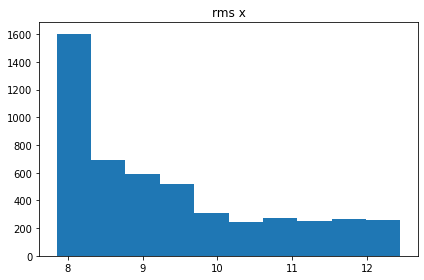

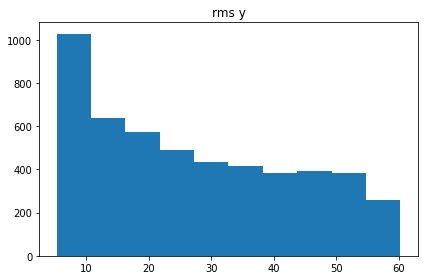

In [9]:
for idx, col in enumerate(X_vals.T):
    fig, ax = plt.subplots()
    ax.hist(col)
    ax.set_title(x_labels[idx])
    fig.tight_layout()

In [10]:
############# normalize parameter offsets 
transformer_y = RobustScaler().fit(settings)
Y_scaled = transformer_y.transform(settings)
print(np.max(Y_scaled))
print(np.min(Y_scaled))

1.0319019681705826
-1.0201821084371225


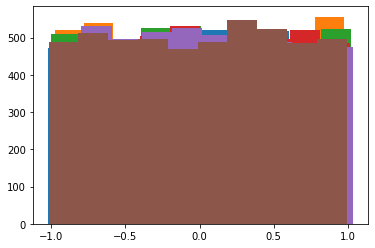

In [11]:
############# beautiful plot to make sure you actually normalized everything 
for i in range(Y_scaled.shape[1]):
    plt.hist(Y_scaled[:, i])
plt.show()

In [12]:
transformer_x = RobustScaler().fit(X_vals)
X_scaled = transformer_x.transform(X_vals)
print(np.max(X_scaled))
print(np.min(X_scaled))

1.7132636015714668
-1.024073949024662


In [13]:
############# split train/test data 
split = 80
y_train, y_val, x_train, x_val = train_test_split(Y_scaled, X_scaled, 
                                                test_size = (100 - split) / 100.,
                                                random_state = 42) 

print(y_train.shape)
print(x_train.shape)

(4000, 6)
(4000, 4)


In [14]:
print(x_train.shape)
print(x_val.shape)
print(np.shape(y_val))

(4000, 4)
(1000, 4)
(1000, 6)


## Model

In [15]:
# layers
layer_size = [20, 40, 60, 100, 200]
layer_type = ['tanh', 'relu', 'tanh', 'tanh', 'tanh']

# check that we didn't mess this up
assert len(layer_size) == len(layer_type)

# gaussian noise regularization
noise_level = .1

In [16]:
model = Sequential() ## initial feed forward model 

# add the input layer
model.add(Dense(x_train.shape[1], 
                activation='linear', 
                input_dim=x_train.shape[1]))

for idx, size in enumerate(layer_size):
    model.add(Dense(size, 
                    activation=layer_type[idx])) #, kernel_regularizer=keras.regularizers.l2(l=0.0001)
    #model.add(GaussianNoise(noise_level))
    
# add the output layer
model.add(Dense(y_train.shape[1], 
                activation='linear'))

opt = keras.optimizers.Adam(learning_rate=0.01)
    
model.compile(optimizer=opt, loss='mean_squared_error') ## setup the optimizer and loss function
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6100      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1

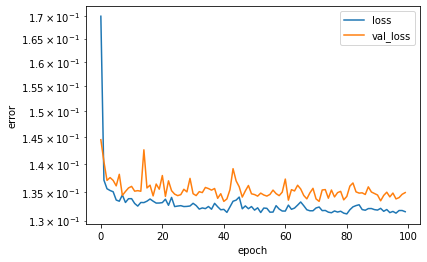

Time to train model: 1.5239611228307088 minutes


In [17]:
n_epochs = 100
start = time.time()
hist = model.fit(x=x_train, y=y_train, 
                validation_data= (x_val, y_val),
                 batch_size = 128,
                 shuffle = 'true',
                 epochs = n_epochs,
                 verbose = 'false',
                 callbacks = [plot_losses])
end = time.time()
print('Time to train model: ' + str((end - start)/60) + ' minutes')


# Eval Model

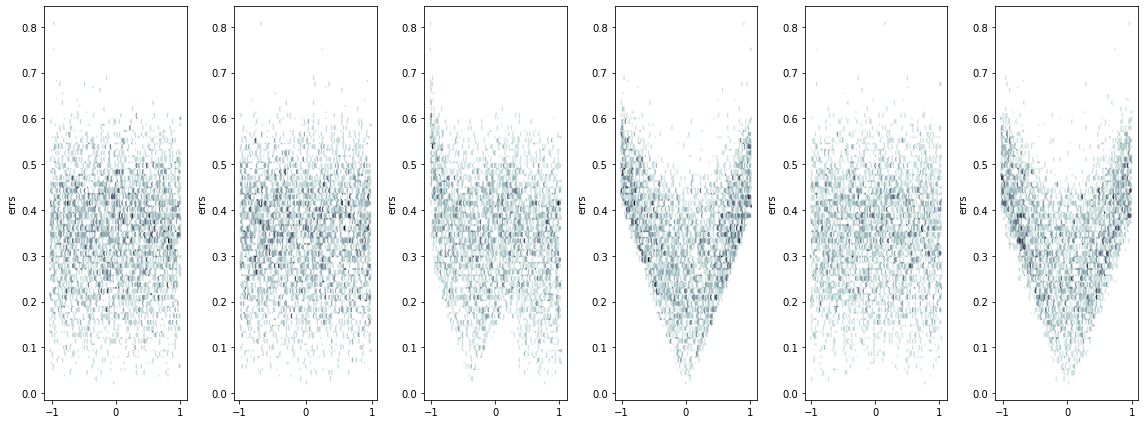

In [18]:
fig, axs = plt.subplots(1, np.shape(y_val)[1], figsize=(16, 6))
preds = model.predict(X_scaled)
errs = np.sqrt(np.mean((Y_scaled - preds)**2, axis=1))

for idx in range(np.shape(y_val)[1]):
    axs[idx].hexbin(Y_scaled[:,idx], errs, cmap = 'bone_r')
    #axs[idx].set_xlabel(y_labels[idx])
    axs[idx].set_ylabel('errs')
fig.tight_layout()
fig.savefig('rms_model_errs_corr.png')

NameError: name 'Y_vals' is not defined

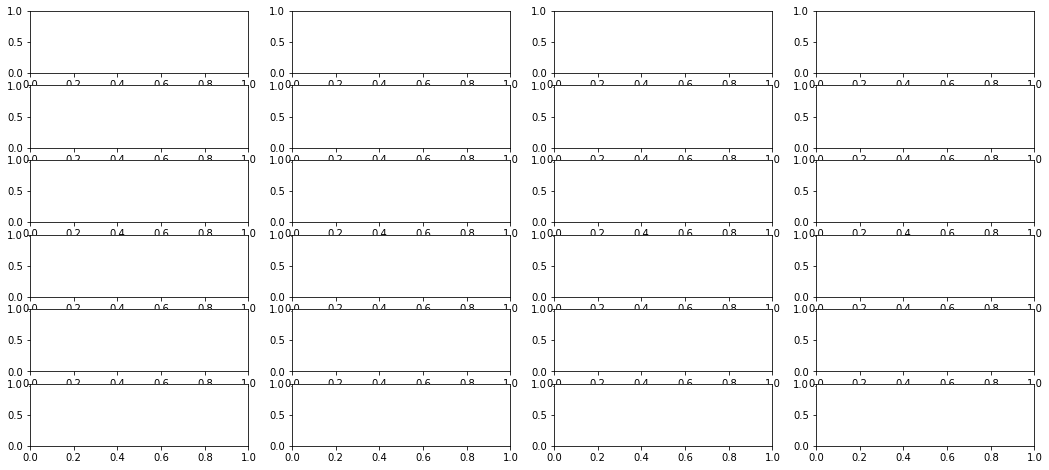

In [19]:
fig, axs = plt.subplots(np.shape(y_val)[1], np.shape(x_val)[1], figsize=(18, 8))
for idx in range(np.shape(Y_scaled)[1]):
    for jdx in range(np.shape(X_scaled)[1]):
        axs[idx, jdx].hexbin(settings[:,jdx], Y_vals[:,idx], cmap = 'bone_r')
        axs[idx, jdx].set_xlabel(labels[jdx])
        axs[idx, jdx].set_ylabel(y_labels[idx])
        axs[idx, jdx].ticklabel_format(axis='x', style='sci')
fig.tight_layout()
fig.savefig('srw_correlations.png')